
# Lista 5

## Zuzanna Sosnowska

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate as interp
from scipy.optimize import fsolve, curve_fit

from typing import Callable

In [28]:
def polynomial(coef) -> Callable:
    """
    Funkcja zwraca wielomian (funkcję) o zadanych współczynnikach
    :param coef: Lista współczynników, zaczynająca się od wyrazu wolnego i kończąca na współczynniku przy najwyższej potędze
    :return: Funkcja zwraca funkcję, obliczającą wartość wielomianu o zadanych współczynnikach w punkcie.
    """
    return lambda x : sum(coef[i] * x ** i for i in range(len(coef)))


def st_dev(func, points) -> np.float64:
    """
    Funkcja oblicza odchylenie standardowe od rzeczywistych wartości dla aproksymacji funkcji
    :param func: Funkcja aproksymująca
    :param points: Punkty, na podstawie których obliczono wartość funkcji aproksymującej (z dokładną wartością funkcji w zadanych punktach)
    :return: Funkcja zwraca odchylenie standardowe
    """
    return np.sqrt(variance(func=func, points=points))


def variance(func, points) -> np.float64:
    """
    Funkcja oblicza wariancję od rzeczywistych wartości dla aproksymacji funkcji
    :param func: Funkcja aproksymująca
    :param points: Punkty, na podstawie których obliczono wartość funkcji aproksymującej (z dokładną wartością funkcji w zadanych punktach)
    :return: Funkcja zwraca wariancję
    """
    x, y = zip(*points)
    x, y = np.array(x), np.array(y)
    n = len(points)
    f_x = func(x)
    return 1 / n * np.sum(np.power(y - f_x, 2))


def mean_abs_dev(func, points) -> np.float64:
    """
    Funkcja oblicza średnie odchylenie bezwzględne od rzeczywistych wartości dla aproksymacji funkcji
    :param func: Funkcja aproksymująca
    :param points: Punkty, na podstawie których obliczono wartość funkcji aproksymującej (z dokładną wartością funkcji w zadanych punktach)
    :return: Funkcja zwraca średnie odchylenie bezwzględne
    """
    x, y = zip(*points)
    x, y = np.array(x), np.array(y)
    n = len(points)
    f_x = func(x)
    return 1 / n * np.sum(np.abs(y - f_x))

In [29]:
# Klasy zaimplementowane na liście 2, służą do rozwiązywania układów równań

from typing import Iterable
import copy

class Vector(Iterable):
    def __init__(self, elems=None):
        if elems is None:
            elems = []
        self.__elems = elems

    def __getitem__(self, key):
        return self.__elems[key]

    def __setitem__(self, key, val):
        self.__elems[key] = val

    def __len__(self):
        return len(self.__elems)

    def __iter__(self):
        return self.__elems.__iter__()

    def __add__(self, other):
        if len(self) != len(other):
            raise ValueError("Vector must be of equal length")
        return Vector([a + b for a, b in zip(self, other)])

    def __neg__(self):
        return Vector([-a for a in self.__elems])

    def __sub__(self, other):
        if len(self) != len(other):
            raise ValueError("Vector must be of equal length")
        return Vector([a - b for a, b in zip(self, other)])

    def __mul__(self, other):
        if len(self) != len(other):
            raise ValueError("Vector must be of equal length")
        return Vector([a * b for a, b in zip(self, other)])

    def __rmul__(self, other):
        return Vector([other * a for a in self.__elems])

    def __str__(self):
        comma_list = ''.join([str(a) + ', ' for a in self.__elems])
        return '<' + comma_list[:-2] + '>'

    def copy(self):
        return Vector([*self.__elems])

    def append(self, val):
        self.__elems.append(val)

    def norm(self):
        return sum(map(lambda x: abs(x), self.__elems))

    def norm_inf(self):
        return max(map(lambda x: abs(x), self.__elems))

class Matrix:

    def __init__(self):
        self.__rows = []

    @staticmethod
    def from_vectors(vectors):
        m = Matrix()
        for vec in vectors:
            m.add_row(vec)
        return m

    @staticmethod
    def create_from_list(list_of_lists):
        m = Matrix()
        for row in list_of_lists:
            m.add_row(Vector(row))
        return m

    @staticmethod
    def identity_matrix(n):
        I = [[1 if i == j  else 0 for i in range(n)] for j in range(n)]
        return Matrix.create_from_list(I)

    def number_of_rows(self):
        return len(self.__rows)

    def number_of_columns(self):
        return 0 if len(self.__rows) == 0 else len(self.__rows[0])

    def is_empty(self):
        return len(self.__rows) == 0

    def __len__(self):
        return self.number_of_rows() * self.number_of_columns()

    def __getitem__(self, item):
        return self.__rows[item]

    def __setitem__(self, key, new_row):
        self.__rows[key] = new_row

    def __str__(self):
        return ''.join([str(row) + '\n' for row in self.__rows])

    def __rmul__(self, other):
        return Matrix.create_from_list([other * row for row in self.__rows])

    def __sub__(self, other):
        if self.number_of_rows() != other.number_of_rows() and self.number_of_columns() != other.number_of_columns():
            raise ValueError("Matrix has different number of rows and columns")
        res = self.copy()
        for i in range(self.number_of_rows()):
            res[i] -= other[i]

        return res

    def __add__(self, other):
        if self.number_of_rows() != other.number_of_rows() and self.number_of_columns() != other.number_of_columns():
            raise ValueError("Matrix has different number of rows and columns")
        res = self.copy()
        for i in range(self.number_of_rows()):
            res[i] += other[i]

        return res

    def copy(self):
        return Matrix.from_vectors([row.copy() for row in self.__rows])

    def add_row(self, new_row):
        if len(new_row) != self.number_of_columns() and not self.is_empty():
            raise ValueError("Matrix rows must be of equal length")
        self.__rows.append(new_row)

    def add_column(self, new_column):
        if len(new_column) != self.number_of_rows():
            raise ValueError("Matrix columns must be of equal length")
        for i in range(self.number_of_rows()):
            self.__rows[i].append(new_column[i])

    def subtract_rows(self, row1, row2):
        self.__rows[row1] -= self.__rows[row2]

    def multiply_row(self, key, scalar):
        self.__rows[key] *= scalar

    def swap_rows(self, row1, row2):
        self.__rows[row1], self.__rows[row2] = self.__rows[row2], self.__rows[row1]

    def multiply_column(self, column, scalar):
        for row in self.__rows:
            row[column] *= scalar

    def subtract_column(self, index1, index2):
        for row in self.__rows:
            row[index1] -= row[index2]

    def upper_triangular_matrix(self):
        matrix = copy.deepcopy(self)
        if matrix.number_of_rows() == matrix.number_of_columns():
            for j in range(matrix.number_of_columns()):
                find_nullifying_row = False
                for i in range(j, matrix.number_of_rows()):
                    if matrix[i][j] != 0 and find_nullifying_row == False:
                        matrix.swap_rows(i, j)
                        find_nullifying_row = True
                        continue
                    if find_nullifying_row:
                        a = matrix[i][j] / matrix[j][j]
                        matrix[i] = matrix[i] - a * matrix[j]
                if not find_nullifying_row:
                    raise ValueError("Macierz osobliwa")
        return matrix

    def det(self):
        matrix = self.upper_triangular_matrix()
        det = 1
        for i in range(len(self.__rows)):
            det *= matrix[i][i]
        return det

    def multiply_matrix_by_vector(self, vector: Vector) -> Vector:
        if self.number_of_columns() != len(vector):
            raise ValueError("Vector length must be of equal to number of columns in matrix")
        new_vector = Vector()
        for row in self.__rows:
            new_vector.append(sum(row * vector))
        return new_vector

    def inv(self):
        if self.number_of_rows() != self.number_of_columns():
            raise ValueError("Matrix must be of equal length")
        matrix = copy.deepcopy(self)
        n = matrix.number_of_rows()
        I = Matrix.identity_matrix(n)
        for column in range(n):
            find_nullifying_row = False
            for row in range(column, n):
                if matrix[row][column] != 0 and find_nullifying_row == False:
                    matrix.swap_rows(row, column)
                    I.swap_rows(row, column)
                    find_nullifying_row = True
                    continue
                if find_nullifying_row:
                    modifier = matrix[row][column] / matrix[column][column]
                    matrix[row] = matrix[row] - modifier * matrix[column]
                    I[row] = I[row] - modifier * I[column]
            if not find_nullifying_row:
                raise ValueError("Macierz osobliwa")
        for column in range(n - 1, -1, -1):
            for row in range(column):
                modifier = matrix[row][column] / matrix[column][column]
                matrix[row] = matrix[row] - modifier * matrix[column]
                I[row] = I[row] - modifier * I[column]
            modifier = 1 / matrix[column][column]
            I[column] = modifier * I[column]
            matrix[column] = modifier * matrix[column]
        return I

    def norm(self):
        max = 0
        for row in self.__rows:
            if row.norm() > max:
                max = row.norm()
        return max

In [30]:
def polynomial_interpolation(points) -> Callable:
    """
    Funkcja oblicza interpolację wielomianową dla zadanych punktów.
    :param points: Punkty, w których będziemy obliczać interpolację wielomianową.
    :return: Funkcja zwraca wielomian (funkcję) o obliczonych na podstawie punktów współczynnikach .
    """
    n = len(points)
    # Tworzenie macierzy układu równań
    matrix_lst = []
    for i in range(n):
        row = np.zeros(n)
        for j in range(n):
            row[j] = points[i][0] ** j
        matrix_lst.append(row)

    A = Matrix.create_from_list(matrix_lst)
    b = Vector([points[i][1] for i in range(n)])
    A_inv = A.inv()
    # Współczynniki wielomianu interpolującego są rozwiązaniem układu równań liniowych
    coeffs = A_inv.multiply_matrix_by_vector(b)
    return polynomial(coef=coeffs)


def lagrange_implemented(x, points) -> np.float64:
    """
    Funkcja oblicza wartość wielomianu interpolującego metodą Lagrange'a.
    :param x: Punkt, w którym obliczana jest wartość wielomianu interpolującego.
    :param points: Węzły interpolacji
    :return: Funkcja zwraca wartość wielomianu interpolującego w danym punkcie x dla zadanych punktów węzłowych. 
    """
    x_data, y_data = zip(*points)
    n = len(points)
    y = 0
    for i in range(n):
        w = 1.0
        for j in range(n):
            if i != j:
                w = w * (x - x_data[j]) / (x_data[i] - x_data[j])
        y = y + w * y_data[i]
    return y

### Zadanie 1

Celem zadania było przedstawienie zależności gęstości powietrza $\rho$ od wysokości $h$ w postaci funkcji kwadratowej $\rho(h)$. Otrzymane dane to:

| $h$ (km) | $\rho (\frac{kg}{m^3})$ |
|----------|-------------------------|
| 0        | 1.225                   |
| 3        | 0.905                   |
| 6        | 0.652                   |

Udało mi się zaimplementować w Pythonie funkcję, która oblicza współczynniki funkcji kwadratowej przy wykorzystaniu interpolacji , osiągając wyniki zbliżone do tych, jakie oferuje funkcja biblioteczna (`scipy.interpolate.lagrange`). Wyniki zostały przedstawione na wykresie w celu lepszego zobrazowania, jak wyprowadzona funkcja kwadratowa odwzorowuje zależność danych. 

Specjalnie wykreślono wykres na szerszym przedziale wysokości \( h \), aby zilustrować zachowanie funkcji interpolującej poza danymi punktami pomiarowymi. Dzięki temu widoczne jest, że interpolacja w istocie realizowana jest za pomocą funkcji kwadratowej.

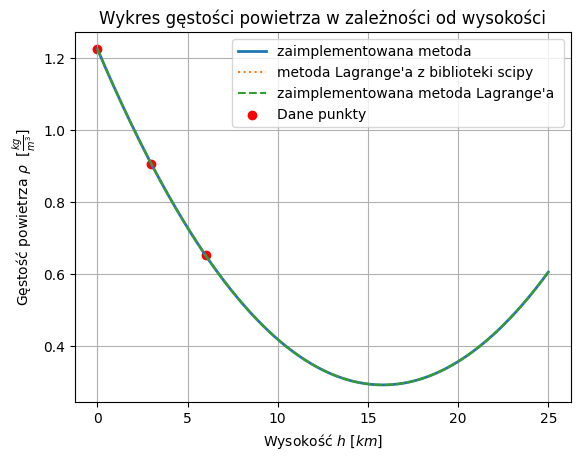

In [31]:
h_lst = np.array([0.0, 3.0, 6.0])
ro_lst = np.array([1.225, 0.905, 0.652])
points = list(zip(h_lst, ro_lst))

# Zaimplementowana metoda
poly = polynomial_interpolation(points)
# Lagrange z biblioteki scipy
poly2 = interp.lagrange(h_lst, ro_lst)

h = np.linspace(0, 25, 1000)
ro = poly(h)
ro2 = poly2(h)
ro3 = lagrange_implemented(h, points)

plt.plot(h, ro, label='zaimplementowana metoda', linewidth=2)
plt.plot(h, ro2, label='metoda Lagrange\'a z biblioteki scipy ', linestyle=':')
plt.plot(h, ro3, label='zaimplementowana metoda Lagrange\'a ', linestyle='--')
plt.scatter(h_lst, ro_lst, color='red', label='Dane punkty')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel(r"Wysokość $h$ $[km]$")
plt.ylabel(r"Gęstość powietrza $\rho$  $[\frac{kg}{m^3}]$")
plt.title("Wykres gęstości powietrza w zależności od wysokości")
plt.show()

### Zadanie 2

W poniższej tabeli przedstawiono współczynnik oporu $c_D$ sfery w cieczy jako funkcję liczby Reynoldsa $Re$:

| $ Re $ | $ c_D $ |
|--------|---------|
| 0.2    | 103     |
| 2      | 13.9    |
| 20     | 2.72    |
| 200    | 0.8     |
| 2000   | 0.401   |
| 20000  | 0.43    |

Do interpolacji wykorzystałam funkcje z biblioteki `scipy`, stosując naturalne funkcje składane (`spline`, `bc_type='natural'`). Otrzymane wyniki pozwoliły na wyznaczenie wartości $c_D$ dla $Re = 5$, $Re = 50$, i $Re = 5000$.

Należy jednak zauważyć, że punkty danych w tabeli są od siebie dość mocno oddalone, co powoduje, że wyniki interpolacji mogą różnić się w zależności od użytej metody. Interpolacja za pomocą funkcji sklejanych okazała się dobrze odwzorowywać dostępne dane, ale dla bardzo dużych lub bardzo małych wartości liczby Reynoldsa potencjalna dokładność oszacowania jest ograniczona przez rozstrzał danych wejściowych.

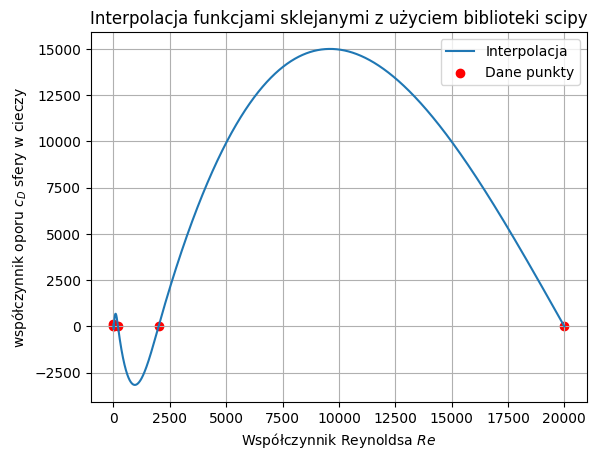

Wartości współczynnika oporu dla Re = 5, 50, 5000: [ -88.94021032  458.28842121 9920.95571242]


In [32]:
re_lst = [0.2, 2, 20, 200, 2000, 20000]
cd_lst = [103, 13.9, 2.72, 0.8, 0.401, 0.433]
Re = [5, 50, 5000]

# Interpolacja funkcjami sklejanymi z biblioteki scipy
cs = interp.make_interp_spline(x=re_lst, y=cd_lst, bc_type="natural")

x_lst = np.linspace(0, 20000, 100000)
y1_lst = cs(x_lst)
cD = cs(Re)

plt.plot(x_lst, y1_lst, label='Interpolacja')
plt.scatter(re_lst, cd_lst, label='Dane punkty', color='red')
plt.legend()
plt.grid(True)
plt.title("Interpolacja funkcjami sklejanymi z użyciem biblioteki scipy")
plt.xlabel(r"Współczynnik Reynoldsa $Re$")
plt.ylabel(r"współczynnik oporu $c_D$ sfery w cieczy")
plt.show()

print("Wartości współczynnika oporu dla Re = 5, 50, 5000:", cD)

### Zadanie 3

Celem zadania 3 było porównanie interpolacji funkcjami sklejanymi, zastosowanej w zadaniu 2, do interpolacji wielomianowej. Chociaż obie metody dokładnie odwzorowują zadane punkty pomiarowe, ich zachowanie pomiędzy punktami znacznie się różni.

Interpolacja wielomianowa, choć przechodzi przez wszystkie dane punkty, wykazuje charakterystyczne oscylacje pomiędzy węzłami, szczególnie widoczne w przypadku danych mocno od siebie oddalonych, jak w tym zadaniu. W efekcie, interpolowana funkcja przyjmuje nietypowe wartości dla punktów spoza węzłów, co ilustruje problemy tej metody.

Z kolei funkcje składane, stosowane w zadaniu 2, pozwalają uzyskać gładką interpolację, lepiej odwzorowującą rzeczywiste zależności w danych. Wyniki pokazują, że metoda wielomianowa jest mniej stabilna, szczególnie dla danych o dużym rozstrzale.

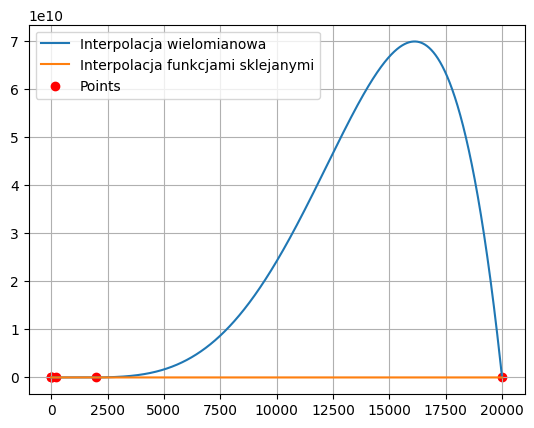

Wartości współczynnika oporu (z użyciem interpolacji funkcjami sklejanymi) dla Re = 5, 50, 5000: [ -88.94021032  458.28842121 9920.95571242]
Wartości współczynnika oporu (z użyciem interpolacji wielomianowej) dla Re = 5, 50, 5000: [-9.61004621e+01  2.58114412e+03  1.65845517e+09]


In [33]:
points = [(re_lst[i], cd_lst[i]) for i in range(len(re_lst))]
poly = polynomial_interpolation(points)

y2_lst = poly(x_lst)
cD2 = poly(np.array(Re))

plt.plot(x_lst, y2_lst, label='Interpolacja wielomianowa')
plt.plot(x_lst, y1_lst, label='Interpolacja funkcjami sklejanymi')
plt.scatter(re_lst, cd_lst, label='Points', color='red')
plt.legend()
plt.grid(True)
plt.show()

print("Wartości współczynnika oporu (z użyciem interpolacji funkcjami sklejanymi) dla Re = 5, 50, 5000:", cD)
print("Wartości współczynnika oporu (z użyciem interpolacji wielomianowej) dla Re = 5, 50, 5000:", cD2)

In [34]:
def polynomial_approximation(points, polynom_deg):
    """
    Funkcja oblicza numerycznie aproksymację wielomianową metodą najmniejszych kwadratów.
    :param points: Punkty, dla których funkcja będzie obliczać aproksymację wielomianową.
    :param polynom_deg: Stopień wielomianu aproksymującego.
    :return: Funkcja zwraca listę współczynników wielomianu aproksymującego.
    """
    def x_i(x, i): 
        return np.sum(np.power(x, i))
    
    def xy_i(x, y, i): 
        return np.sum(np.power(x, i) * y)
    
    k = polynom_deg
    n = len(points)
    x, y = zip(*points)
    b = Vector([xy_i(x, y, i) for i in range(k+1)])
    matrix_lst = []
    matrix_row = [n] + [x_i(x, i) for i in range(1, k+1)]
    matrix_lst.append(matrix_row[:])
    for i in range(1, k+1):
        matrix_row.pop(0)
        matrix_row.append(x_i(x, k+i))
        matrix_lst.append(matrix_row[:])
    A = Matrix.create_from_list(matrix_lst)
    A_inv = A.inv()
    return A_inv.multiply_matrix_by_vector(b)


def curve_fit_implemented(points, func, derivative_vector):
    """
    Funkcja oblicza współczynniki, dla których dana funkcja najlepiej aproksymuje zadane punkty.
    :param points: Punkty, dla których obliczamy funckję aproksymującą
    :param func: Funkcja, którą zamierzamy aproksymować dane punkty o nieznanych parametrach, które obliczamy numerycznie
    :param derivative_vector: Wektor pochodnych cząstkowych zadanej funkcji 
    :return: Funkcja zwraca wektor współczynników, dla których zadana funkcja najlepiej aproksymuje podane punkty.
    """
    # Funkcja obliczająca normę
    def norm(x): return np.sqrt(np.sum(x**2))
    
    # Funkcja do odpowiedniego wypakowywania wektora pochodnych
    def get_g_functions(points, func, derivative):
        x, y = zip(*points)
        x, y = np.array(x), np.array(y)
        return lambda params: np.sum((y - func(x, params)) * derivative(x, params))
    
    x, y = zip(*points)
    g_func_vector = []
    n = len(derivative_vector)
    for derivative in derivative_vector:
        g_func_vector.append(get_g_functions(points, func, derivative))
        
    # Numeryczne rozwiązywanie układu równań nieliniowych z odpowiednio dobranymi parametrami. Podobne działania co w zadaniu 5 z listy 4, rozszerzone na wiele wymiarów, metoda uniwersalna, dla uproszczenia wykorzystałam funkcję z biblioteki scipy.optimize
    solutions = fsolve(lambda t: [g_func_vector[i](t) for i in range(n)], np.ones(n))
    return solutions

### Zadanie 4

W zadaniu należało wyznaczyć parametry $ a $ i  $ b $, aby funkcja $ f(x) = a e^{bx} $ aproksymowała dane w sensie najmniejszych kwadratów:

| $ x $ | $ y $ |
|-------|-------|
| 1.2   | 7.5   |
| 2.8   | 16.1  |
| 4.3   | 38.9  |
| 5.4   | 67.0  |
| 6.8   | 146.6 |
| 7.9   | 266.2 |


**Metoda I**

Aby upraszczać aproksymację, można przekształcić funkcję $ f(x) = a e^{bx} $ do postaci liniowej, stosując logarytm naturalny. Po przekształceniu mamy:

$$
\ln(y) = \ln(a) + b \cdot x = a' + b \cdot x
$$

Gdzie:
- $ c = \ln(a) $, czyli funkcja sprowadza się do postaci liniowej $ y_2 = c + b \cdot x $, gdzie $ y_2 = \ln(y) $.

Dla danych w tej postaci używamy metody najmniejszych kwadratów, aby wyznaczyć $ c $ i $ b $, a następnie $ a = e^{c} $.

**Ogólny wzór funkcji aproksymacyjnej:**

Dla danych punktów $(x_i, y_i)$, gdzie $ y $ jest funkcją wielomianu $ n $-tego stopnia:
$$
y = a_0 + a_1 x + a_2 x^2 + \dots + a_n x^n
$$
funkcja błędu średniokwadratowego $ S(x) $ dana jest jako:
$$
S(x) = \sum_{i=0}^k \left(y_i - a_0 - a_1 x_i - a_2 x_i^2 - \dots - a_n x_i^n\right)^2
$$

Aby znaleźć parametry minimalizujące błąd $ S(x) $, obliczamy pochodne cząstkowe względem parametrów $ a_0, a_1, \dots, a_n $:
$$
\frac{\partial S}{\partial a_0} = -2 \sum_{i=0}^k \left(y_i - a_0 - a_1 x_i - a_2 x_i^2 - \dots - a_n x_i^n\right)
$$
$$
\frac{\partial S}{\partial a_1} = -2 \sum_{i=0}^k \left(y_i - a_0 - a_1 x_i - a_2 x_i^2 - \dots - a_n x_i^n\right) x_i
$$
$$
\frac{\partial S}{\partial a_2} = -2 \sum_{i=0}^k \left(y_i - a_0 - a_1 x_i - a_2 x_i^2 - \dots - a_n x_i^n\right) x_i^2
$$
$$
\vdots
$$
$$
\frac{\partial S}{\partial a_n} = -2 \sum_{i=0}^k \left(y_i - a_0 - a_1 x_i - a_2 x_i^2 - \dots - a_n x_i^n\right) x_i^n
$$

Przyrównujemy każdą z pochodnych do zera i rozwiązujemy układ równań liniowych, aby znaleźć estymatory parametrów $ a_0, a_1, \dots, a_n $. W przypadku tego zadania uwzględniamy jedynie $ a_0 $ i $ a_1 $ jako niezerowe, ponieważ zależność jest liniowa w przestrzeni logarytmowanej.

**Wynik:** Tak obliczone estymatory pozwalają wyznaczyć $ c $ i $ b $, a stąd parametry $ a $ i $ b $ dla funkcji wykładniczej $ f(x) = a e^{bx} $.



**Metoda II**

Drugie podejście do wyznaczania parametrów $a$ i $b$ dla funkcji $f(x) = a e^{bx}$ opiera się na bezpośredniej minimalizacji błędu średniokwadratowego $S(x)$, bez wcześniejszego logarytmowania danych. 

Funkcja błędu $S(x)$ jest zapisana jako:
$$
S(x) = \sum_{i=0}^k \left( y_i - a e^{b x_i} \right)^2
$$

**Pochodne funkcji $S(x)$:**

Aby znaleźć parametry $a$ i $b$, minimalizujemy $S(x)$, obliczając jej pochodne cząstkowe:
$$
\frac{\partial S}{\partial a} = 2 \sum_{i=0}^k \left( y_i - a e^{b x_i} \right) \cdot e^{b x_i}
$$
$$
\frac{\partial S}{\partial b} = 2 \sum_{i=0}^k \left( y_i - a e^{b x_i} \right) \cdot a x_i e^{b x_i}
$$

Następnie szukamy parametrów $a$ i $b$, które minimalizują $S(x)$, przyrównując obie pochodne do zera. Otrzymujemy w ten sposób układ równań nieliniowych:
$$
\sum_{i=0}^k \left( y_i - a e^{b x_i} \right) \cdot e^{b x_i} = 0
$$
$$
\sum_{i=0}^k \left( y_i - a e^{b x_i} \right) \cdot a x_i e^{b x_i} = 0
$$

**Rozwiązanie układu równań:**

Układ ten jest rozwiązywany za pomocą funkcji numerycznej, np. wbudowanej w bibliotekę `scipy.optimize` funkcji `fsolve`, która znajduje rozwiązanie układów równań nieliniowych. Alternatywnie można zastosować iteracyjną metodę Newtona, ale jej implementacja jest bardziej skomplikowana, ponieważ wymaga obliczenia i zdefiniowania odpowiedniego Jacobianu, co w przypadku funkcji wykładniczej może być pracochłonne.

Metoda ta, choć bardziej złożona obliczeniowo, pozwala na bezpośrednie wyznaczenie optymalnych parametrów $a$ i $b$, minimalizując funkcję błędu w oryginalnej formie.



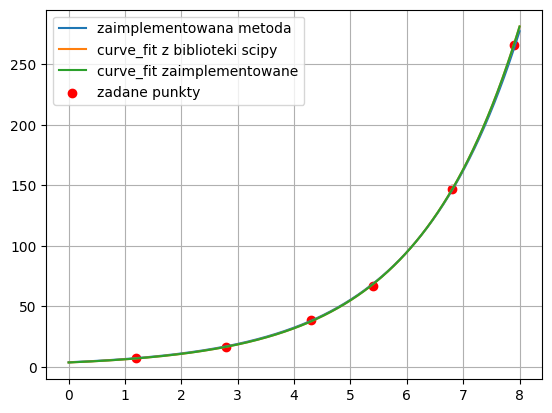

odchylenie standardowe dla zaimplementowanej metody: 1.7139570530426864
odchylenie standardowe dla funkcji z biblioteki: 0.8346646174186034
odchylenie standardowe dla zaimplementowanej metody (wersja 2): 0.8346646174186122


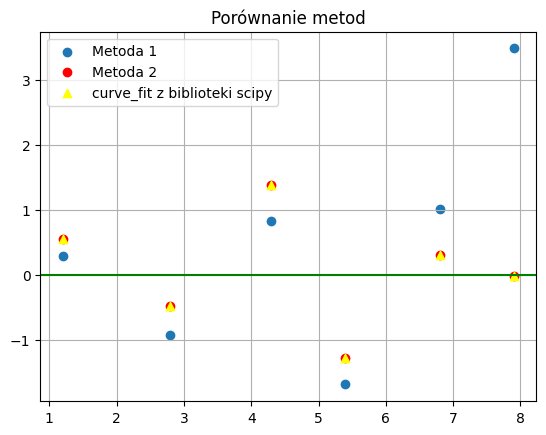

In [35]:
def func(x, params): 
    a, b = params
    return a * np.exp(b * x)


x = np.array([1.2, 2.8, 4.3, 5.4, 6.8, 7.9])
y = np.array([7.5, 16.1, 38.9, 67.0, 146.6, 266.2])

# Metoda polegająca na dopasowaniu prostej regresji, stąd logarytm
points = tuple(zip(x, np.log(y)))

x_lst = np.linspace(0, 8, 1000)
# Dopasowanie prostej regresji (aproksymującej punkty)
c0, c1 = polynomial_approximation(points=points, polynom_deg=1)
b1 = c1
# Obliczenie pierwotnych wartości argumentów
a1 = np.exp(c0)
y1_lst = func(x_lst, [a1, b1])

# Rozwiązanie biblioteczne
sol2, covariance_matrix = curve_fit(lambda t, a, b: func(t, [a, b]), x, y)
a2, b2 = sol2
y2_lst = func(x_lst, [a2, b2])


# Zdefiniowanie pochodnych cząstkowych funkcji f(x)
def a_der(x, params):
    a, b = params
    return np.exp(b * x)


def b_der(x, params):
    a, b = params
    return a * np.exp(b * x) * x

# Obliczenie nieznanych parametrów drugą metodą, z użyciem zaimplementowanego curve_fit
points = list(zip(x, y))
sol3 = curve_fit_implemented(points, func, [a_der, b_der])

a3, b3 = sol3
y3_lst = func(x_lst, [a3, b3])

plt.plot(x_lst, y1_lst, label='zaimplementowana metoda')
plt.plot(x_lst, y2_lst, label='curve_fit z biblioteki scipy')
plt.plot(x_lst, y3_lst, label='curve_fit zaimplementowane')
plt.scatter(x, y, color='red', label='zadane punkty')
plt.legend()
plt.grid(True)
plt.show()

points = tuple(zip(x, y))
print("odchylenie standardowe dla zaimplementowanej metody:", st_dev(func=lambda x: a1 * np.exp(b1 * x), points=points))
print("odchylenie standardowe dla funkcji z biblioteki:", st_dev(func=lambda x: a2 * np.exp(b2 * x), points=points))
print("odchylenie standardowe dla zaimplementowanej metody (wersja 2):", st_dev(func=lambda x: a3 * np.exp(b3 * x), points=points))

# Różnica wartości pomiędzy zadaną wartością, a tą obliczoną z użyciem zaimplementowanych metod 
diff1 = y - func(x, [a1, b1])
diff2 = y - func(x, [a2, b2])
diff3 = y - func(x, [a3, b3])

plt.scatter(x, diff1, label="Metoda 1")
plt.scatter(x, diff3, label="Metoda 2", color='red')
plt.scatter(x, diff2, label="curve_fit z biblioteki scipy", marker='^', color='yellow')
plt.grid(True)
plt.axhline(y=0, color='green')
plt.legend()
plt.title("Porównanie metod")
plt.show()

#### Wnioski

Porównując obie metody aproksymacji danych funkcją $f(x) = a e^{bx}$, można zauważyć następujące zależności:

1. **Dokładność aproksymacji:**
   - Druga metoda (bezpośrednie obliczanie parametrów) dokładniej aproksymuje dane punkty, co widać na wykresie błędów. Wartości błędu uzyskanego w tej metodzie są bliższe 0 niż w metodzie pierwszej (z logarytmowaniem). 
   - Niemniej jednak, w obu przypadkach błędy są stosunkowo małe, a ich wpływ na wartości estymowanych parametrów $a$ i $b$ jest nieistotny.

2. **Koszt obliczeniowy:**
   - Metoda 2 wymaga większego nakładu obliczeniowego, ponieważ rozwiązanie układu równań nieliniowych (np. za pomocą `fsolve`) jest bardziej złożone w porównaniu z liniową aproksymacją zastosowaną w Metodzie 1.
   - Implementacja Metody 2 jest również bardziej wymagająca ze względu na konieczność obsługi funkcji wykładniczej i jej pochodnych.

3. **Praktyczna użyteczność:**
   - Wybór metody zależy od kontekstu i wymagań dokładności. W sytuacjach, gdzie wystarczająca jest mniejsza dokładność, Metoda 1 może być bardziej atrakcyjna z uwagi na prostotę. 
   - Dla dokładniejszych analiz lub sytuacji, gdzie błędy muszą być minimalizowane, lepszym wyborem jest Metoda 2.

Ostatecznie, choć Metoda 2 pozwala na bardziej precyzyjną aproksymację danych, różnice w wynikach parametrów $a$ i $b$ są w obu przypadkach niewielkie i mogą być pominięte w wielu praktycznych zastosowaniach.


### Zadanie 5

Dane do aproksymacji przedstawiono w tabeli:

| $ T \, [^\circ \mathrm{C}] $ | $ \mu_k \, [10^{-3} \, \mathrm{m^2/s}] $ |
|-------------------------------|-------------------------------------------|
| 0                             | 1.79                                      |
| 21.1                          | 1.13                                      |
| 37.8                          | 0.696                                     |
| 54.4                          | 0.519                                     |
| 71.1                          | 0.338                                     |
| 87.8                          | 0.321                                     |
| 100                           | 0.296                                     |

**Metoda aproksymacji:**

Dane zostały aproksymowane wielomianem trzeciego stopnia, wykorzystując metodę podobną do tej opisanej wcześniej. Polegała ona na zminimalizowaniu błędu średniokwadratowego $ S(x) $, dla wielomianu postaci:
$$
\mu_k(T) = a_0 + a_1 T + a_2 T^2 + a_3 T^3
$$
gdzie parametry $ a_0, a_1, a_2, a_3 $ zostały wyznaczone na podstawie danych. Wartości parametrów uzyskano za pomocą metody analitycznej, rozwiązując układ równań wynikających z pochodnych cząstkowych $ \frac{\partial S}{\partial a_i} = 0 $.

**Porównanie z rozwiązaniami bibliotekowymi:**

- Opracowana metoda działa podobnie do standardowych funkcji bibliotecznych, takich jak `curve_fit` z `scipy` czy `polyfit` z `numpy`.
- Dla wielomianów metoda bezpośrednia radzi sobie równie skutecznie, a nawet lepiej, ponieważ obliczanie pochodnych jest proste i nie wymaga stosowania numerycznych metod minimalizacji (jak w metodzie 2 opisanej wcześniej).

**Wnioski:**

1. Uzyskane wyniki są bardzo dokładne, a aproksymowany wielomian dobrze odwzorowuje zmienność kinematycznej lepkości wody w funkcji temperatury.
2. Metoda wielomianowa w tym przypadku jest wystarczająca, gdyż funkcja aproksymacji jest gładka i nie wymaga stosowania bardziej złożonych metod nieliniowych.
3. Obliczona wartość $ \mu_k $ dla wskazanych temperatur ($ T = 10^\circ, 30^\circ, 60^\circ, 90^\circ $) mieści się w zakresie przewidywanym przez aproksymowany wielomian.

Metoda ta, oparta na wyznaczaniu parametrów w sposób analityczny, może być bezproblemowo stosowana dla dowolnych danych, jeśli przybliżenie wielomianowe jest odpowiednim modelem.


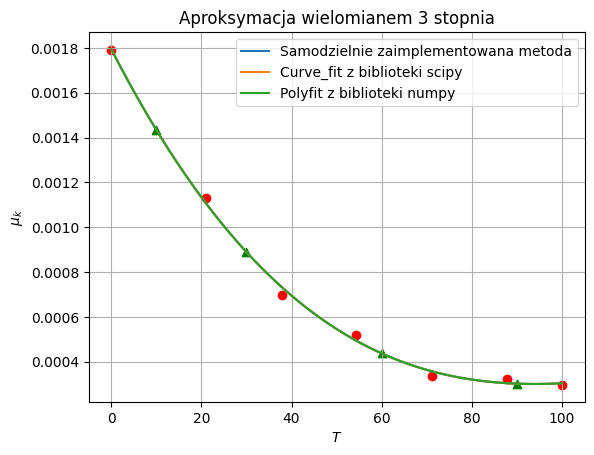

In [36]:
T = np.array([0, 21.1, 37.8, 54.4, 71.1, 87.8, 100])
mi_k = np.array([1.79, 1.13, 0.696, 0.519, 0.338, 0.321, 0.296]) * 10 ** -3

T_lst = np.array([10, 30, 60, 90])


points = tuple(zip(T, mi_k))

# Aproksymacja wielomianem stopnia 3 dla zadanych punktów
coeffs = polynomial_approximation(points=points, polynom_deg=3)

t = np.linspace(0, 100, 1000)
poly = polynomial(coeffs)

# Funkcja biblioteczna curve_fit aproksymująca wielomianem stopnia 3 z biblioteki scipy.optimize
curve_fit(lambda x, a, b, c, d : polynomial([a, b, c, d])(x), T, mi_k)
coeffs2, covariance_matrix = curve_fit(lambda x, a, b, c, d : polynomial([a, b, c, d])(x), T, mi_k)
poly2 = polynomial(coeffs2)

# Funkcja biblioteczna polyfit aproksymująca wielomianem stopnia 3 z biblioteki numpy
coeffs3 = np.polyfit(T, mi_k, 3)[::-1]
poly3 = polynomial(coeffs3)

mi = poly(t)
mi2 = poly2(t)
mi3 = poly3(t)
mi_k_lst = poly(T_lst)

plt.plot(t, mi, label="Samodzielnie zaimplementowana metoda")
plt.plot(t, mi2, label="Curve_fit z biblioteki scipy")
plt.plot(t, mi3, label="Polyfit z biblioteki numpy")
plt.scatter(T, mi_k, color='red')
plt.scatter(T_lst, mi_k_lst, color='green', marker='^')
plt.legend()
plt.xlabel(r'$T$')
plt.ylabel(r'$\mu_k$')
plt.title("Aproksymacja wielomianem 3 stopnia")
plt.grid(True)
plt.show()

### Zadanie 6

Dane do aproksymacji przedstawiono w tabeli:

| $ x$ | $ y $  |
|-------|--------|
| 1.0   | 6.008  |
| 2.5   | 15.722 |
| 3.5   | 27.13  |
| 4.0   | 33.772 |
| 1.1   | 5.257  |
| 1.8   | 9.549  |
| 2.2   | 11.098 |
| 3.7   | 28.828 |

**Przeprowadzone działania:**

1. Aproksymacja danych przy pomocy:
   - funkcji liniowej: $ y = a_0 + a_1 x $,
   - funkcji kwadratowej: $ y = a_0 + a_1 x + a_2 x^2 $.
2. Parametry $a_0, a_1, a_2$ dla obu aproksymacji zostały wyznaczone na podstawie minimalizacji błędu średniokwadratowego $S(x)$ z użyciem aproksymacji wielomianowej, rozwiązując układ równań liniowych uzyskany z pochodnych cząstkowych funkcji $S(x)$.
3. Wyniki aproksymacji porównano z wartościami rzeczywistymi, a funkcje aproksymujące przedstawiono graficznie.


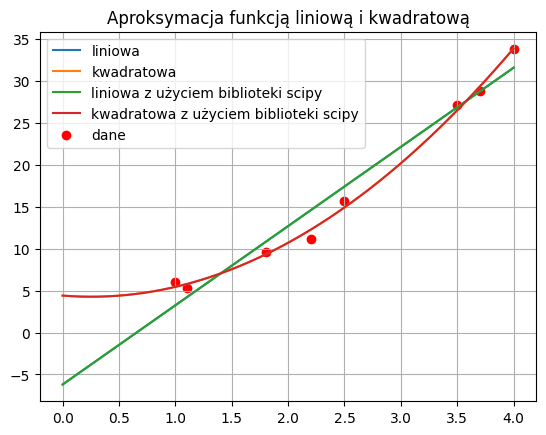

,Metoda,Odchylenie standardowe,Średnie odchylenie bezwzględne
0,Liniowa,1.942983,1.602962
1,Liniowa (scipy),1.942983,1.602962
2,Kwadratowa,0.642676,0.563496
3,Kwadratowa (scipy),0.642676,0.563496


In [37]:
x = np.array([1.0, 2.5, 3.5, 4.0, 1.1, 1.8, 2.2, 3.7])
y = np.array([6.008, 15.722, 27.13, 33.772, 5.257, 9.549, 11.098, 28.828])
points = list(zip(x, y))

# Aproksymacja zaimplementowaną metodą
linear_coeffs = polynomial_approximation(points=points, polynom_deg=1)
quadratic_coeffs = polynomial_approximation(points=points, polynom_deg=2)

# Aproksymacja z użyciem biblioteki scipy
scipy_linear_coeffs, lin_cov_matrix = curve_fit(lambda t, a, b: polynomial([a, b])(t), x, y)
scipy_quadratic_coeffs, quadr_cov_matrix = curve_fit(lambda t, a, b, c: polynomial([a, b, c])(t), x, y)


linear = polynomial(linear_coeffs)
quadratic = polynomial(quadratic_coeffs)

scipy_linear = polynomial(scipy_linear_coeffs)
scipy_quadratic = polynomial(scipy_quadratic_coeffs)

x_lst = np.linspace(0, 4, 1000)
y_linear = linear(x_lst)
y_quadratic = quadratic(x_lst)
y_scipy_linear = scipy_linear(x_lst)
y_scipy_quadratic = scipy_quadratic(x_lst)

plt.plot(x_lst, y_linear, label='liniowa')
plt.plot(x_lst, y_quadratic, label='kwadratowa')
plt.plot(x_lst, y_scipy_linear, label='liniowa z użyciem biblioteki scipy')
plt.plot(x_lst, y_scipy_quadratic, label='kwadratowa z użyciem biblioteki scipy')
plt.scatter(x, y, label='dane', color='red')
plt.legend()
plt.grid(True)
plt.title("Aproksymacja funkcją liniową i kwadratową")
plt.show()

results = {
        "Metoda": [
            "Liniowa",
            "Liniowa (scipy)",
            "Kwadratowa",
            "Kwadratowa (scipy)"
        ],
        "Odchylenie standardowe": [
            st_dev(linear, points),
            st_dev(scipy_linear, points),
            st_dev(quadratic, points),
            st_dev(scipy_quadratic, points)
        ],
        "Średnie odchylenie bezwzględne": [
            mean_abs_dev(linear, points),
            mean_abs_dev(scipy_linear, points),
            mean_abs_dev(quadratic, points),
            mean_abs_dev(scipy_quadratic, points)
        ]
    }

# Tworzenie tabelki z wynikami
pd.DataFrame(results)

### Wnioski
1. **Dokładność aproksymacji:**
   Funkcja kwadratowa lepiej dopasowuje się do danych niż funkcja liniowa, ponieważ bardziej szczegółowo odwzorowuje ich nieliniową zależność.

2. **Uzasadnienie:**
   Wynik jest zgodny z oczekiwaniami, gdyż dane mają charakter nieliniowy, co ogranicza zdolność funkcji liniowej do ich dokładnego aproksymowania.

3. **Zastosowanie metod:**
   Aproksymacja wielomianowa okazała się skuteczna zarówno w przypadku funkcji liniowej, jak i kwadratowej. Parametry wyznaczone za jej pomocą były zgodne z wynikami uzyskiwanymi przy użyciu standardowych narzędzi bibliotecznych, takich jak `scipy.curve_fit`.
